In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install keybert
from keybert import KeyBERT

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import spacy #natural language processing
from spacy.tokens import Doc
import en_core_web_sm
import 
 as pd
import csv
import codecs
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import tokenize # fast sentence tokenization
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize
from collections import Counter
nltk.download('wordnet')
nltk.download('omw-1.4')
import string
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from transformers import pipeline

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


ModuleNotFoundError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Cleaning


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/iCareNetwork/CMS_PUBLIC_COMMENTS_2022_7-9.csv")
df.shape

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (7,10,11,21,30,38,39,57) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(22395, 60)

In [ ]:
# drop columns where 80% contains null values
df = df.dropna(thresh=df.shape[0]*0.8,how='all',axis=1) # 43 columns dropped

# drop rows where there is no comment
df = df.dropna(subset=['Comment'])

In [ ]:
# Delete duplicate rows based on specific columns 
df.drop_duplicates(subset=["Comment"], keep='first', inplace=True)
print(df.shape) # 13358 duplicate rows are dropped

(6036, 17)


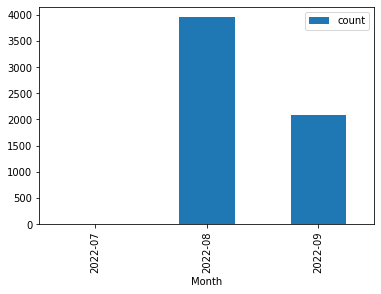

In [ ]:
# Define function to plot count by distribution
def plot_dates(df, col):
  df[col] = pd.to_datetime(df[col])
  df['Month'] = df[col].map(lambda dt: dt.strftime('%Y-%m'))
  grouped_df = df.groupby('Month').size().to_frame("count").reset_index()
  grouped_df.plot(kind='bar', x='Month', y='count')
  plt.show()
plot_dates(df, 'Received Date') # most comments are from Aug 2022

# Top Words

In [ ]:
comments = df['Comment'].to_numpy() # extract all comments into an array

tknzr = TweetTokenizer()
nlp = spacy.load("en_core_web_sm") # NLP for english
lemmatizer = WordNetLemmatizer()

# customized a class for tweet tokenizer
def tweet_tokenize(x):
    return Doc(nlp.vocab, words = tknzr.tokenize(x))

# set our nlp pipeline with tokenizer specialized for tweets
nlp.tokenizer = tweet_tokenize

processed_comments = []

# count top words in different categories
all_counter = Counter()
adj_counter = Counter()
noun_counter = Counter()
verb_counter = Counter()

useful_words = []
adjs = []
nouns = []
verbs = []

remove_words = ['<br/>']

entity_list = []

# loop over each comment
for comment in comments:
    
    processed_comment = []
    
    # Convert comment into Doc object with a sequence of tokens
    for token in nlp(str(comment).lower()):
        if token.text in nlp.Defaults.stop_words or 'http' in token.text or token.text in string.punctuation or len(token.text) < 2 or token.text in remove_words: # remove stop words
            continue
        else:
            useful_words.append(token.text)
            processed_comment.append(lemmatizer.lemmatize(token.text))
        if token.pos_ == 'ADJ':
            adjs.append(token.text)
        elif token.pos_ == 'NOUN':
            nouns.append(token.text)
        elif token.pos_ == 'VERB':
            verbs.append(token.text)
            
    for x in nlp(str(comment).lower()).ents:
        if len(x.text) < 2 or x.text.isnumeric():
            continue
        else:
            entity_list.append(x.text.lower())
  
    processed_comments.append(' '.join(processed_comment))

all_counter.update(useful_words)
adj_counter.update(adjs)
noun_counter.update(nouns)
verb_counter.update(verbs)


In [ ]:
print('Overall Top 10:\n')
print(all_counter.most_common(10))
print('-----------------------------------\n')
print('Adjectives Top 10:\n')
print(adj_counter.most_common(10))
print('-----------------------------------\n')
print('Nouns Top 10:\n')
print(noun_counter.most_common(10))
print('-----------------------------------\n')
print('Verbs Top 10:\n')
print(verb_counter.most_common(10))

Overall Top 10:

[('services', 33062), ('cms', 28732), ('patients', 22148), ('health', 19614), ('care', 18837), ('medicare', 17899), ('access', 16054), ('cuts', 15917), ('management', 15208), ('therapy', 13823)]
-----------------------------------

Adjectives Top 10:

[('behavioral', 8567), ('physical', 7607), ('mental', 7132), ('new', 5060), ('patient', 4928), ('underserved', 4749), ('additional', 4053), ('remote', 3828), ('digital', 3632), ('rural', 3571)]
-----------------------------------

Nouns Top 10:

[('services', 32921), ('patients', 22113), ('health', 19471), ('care', 18588), ('management', 15206), ('therapy', 13821), ('access', 13364), ('cuts', 13313), ('codes', 13282), ('psychologists', 10406)]
-----------------------------------

Verbs Top 10:

[('proposed', 12374), ('urge', 6682), ('provided', 6444), ('ensure', 5038), ('allow', 4672), ('support', 4426), ('ask', 3921), ('appreciate', 3022), ('recognize', 2741), ('underutilized', 2739)]


In [ ]:
Counter(entity_list).most_common(10) 

[('medicare', 14305),
 ('one', 1929),
 ('first', 1587),
 ('two', 1373),
 ('medicare & medicaid services', 1365),
 ('4.4 %', 1297),
 ('previous years', 1272),
 ('between 2020 and 2024', 1265),
 ('up to 40 %', 1249),
 ('approximately 9 %', 1247)]

# Keywords

In [ ]:
kw_model = KeyBERT()

# Extract keywords from each comment

comments = df['Comment'].to_numpy() # extract all comments into an array
keywords = kw_model.extract_keywords(comments,keyphrase_ngram_range=(1, 2), stop_words=None)
keywords

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

[[('integrated care', 0.4676),
  ('community medicare', 0.4648),
  ('psychological services', 0.4554),
  ('health integration', 0.4347),
  ('physicians services', 0.4311)],
 [('community medicare', 0.4741),
  ('psychological services', 0.4573),
  ('integrated care', 0.4498),
  ('physicians services', 0.4464),
  ('medicare', 0.4444)],
 [('psychological services', 0.4846),
  ('integrated care', 0.4673),
  ('community medicare', 0.4606),
  ('licensed psychologist', 0.4482),
  ('health integration', 0.4434)],
 [('community medicare', 0.4688),
  ('integrated care', 0.4565),
  ('psychological services', 0.4554),
  ('medicare', 0.4499),
  ('physicians services', 0.4476)],
 [('licensed psychologist', 0.4426),
  ('physicians services', 0.4345),
  ('community medicare', 0.4344),
  ('health integration', 0.432),
  ('integrated care', 0.4269)],
 [('psychological services', 0.4671),
  ('licensed psychologist', 0.4579),
  ('community medicare', 0.452),
  ('integrated care', 0.4495),
  ('physicians s

In [ ]:
# Extract keywords from all comments
all_comments = ""
for i in range(0,len(df['Comment'])):
   all_comments  = all_comments  + " " + str(df['Comment'].iloc[i])

keywords_comments = kw_model.extract_keywords(all_comments,keyphrase_ngram_range=(1, 2), stop_words=None)
keywords_comments

[('medicare cms', 0.5918),
 ('cms medicare', 0.5861),
 ('psychology medicare', 0.5728),
 ('medicaid cms', 0.5608),
 ('psychologist medicare', 0.5517)]

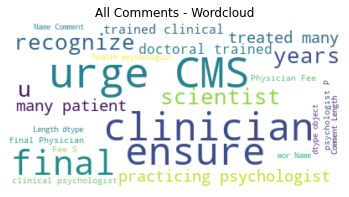

In [ ]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS
 
# Wordcloud with all comments
comments = df['Comment']
stop_words = ["https", "co", "RT"] + list(STOPWORDS)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", stopwords = stop_words, collocation_threshold = 2).generate(str(comments))
plt.figure()
plt.title("All Comments - Wordcloud")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
# categorizing comments into groups (what are the topics around policies, diseases, ...) # bucket them by LOS, diabetes, CGM, procesures...
# sentiment analysis (is a comment a recommendation or rant?)
# goal: 
# 1) use the insights from unstructured data to feed our recommendation engine; 
# 2) make the review process more efficient, integrate the new automated processs with the exisiting comment review process


# manual rules
#df_regulations_bah1_sent1_cat1_con1_geo1['recommend_sent1'] = df_regulations_bah1_sent1_cat1_con1_geo1['comment'].str.extract(r'([^.]*recommend[^.]*)', flags=re.IGNORECASE)
#df_regulations_bah1_sent1_cat1_con1_geo1['recommend_sent1'] = df_regulations_bah1_sent1_cat1_con1_geo1['recommend_sent1'].replace(np.nan, "Not Applicable")


# Extract Recommendations

In [ ]:
# filter dataset to include only comments with intention of making recommendations
recommend_df = df[df["Comment"].str.contains("urge", case=False)] # 239 rows
shape(recommend_df)

NameError: ignored

In [ ]:
# Extract keywords from each recommendations comments
recommendations = recommend_df['Comment'].to_numpy() # extract all comments into an array
keywords = kw_model.extract_keywords(recommendations,keyphrase_ngram_range=(1, 2), stop_words=None)
keywords

In [ ]:
# Extract keywords from all recommendation comments
all_recommendations = ""
for i in range(0,len(recommend_df['Comment'])):
   all_recommendations  = all_recommendations  + " " + recommend_df['Comment'].iloc[i]

keywords_recommendations = kw_model.extract_keywords(all_recommendations ,keyphrase_ngram_range=(1, 2), stop_words=None)
keywords_recommendations

In [ ]:
# Wordcloud with recommendations comments
recommend_comments = recommend_df['Comment']
stop_words = ["https", "co", "RT"] + list(STOPWORDS)
recommend_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", stopwords = stop_words, collocation_threshold = 2).generate(str(recommend_comments))
plt.figure()
plt.title("Recommendation Comments - Wordcloud")
plt.imshow(recommend_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Sentiment Analysis

In [ ]:
def doSentiment1(str1):
  # Importing TextBlob
  from textblob import TextBlob
  return TextBlob(str1).sentiment.polarity*1

In [ ]:
# preprocessing speeches
df['comment_sentiment'] = df['Comment'].apply(doSentiment1)

df.head()

# Topic Modeling

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import OrderedDict

#build count vectorizer off of cleaned text
tf_vectorizer = CountVectorizer()
tf_vectorizer.fit(processed_comments)

In [ ]:
#term-frequency inverse document frequency vectorizer
#dimensions of both vectorizers should match
dtm_tf = tf_vectorizer.transform(processed_comments)
print("shape of term frequency matrix: ", dtm_tf.shape)

tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())
dtm_tfidf = tfidf_vectorizer.fit_transform(processed_comments)
print("shape of term frequency inverse document frequency matrix: ",dtm_tfidf.shape)

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
n_topics = 8
#Singular Value Decomposition
svd = TruncatedSVD(n_components = n_topics)
svdMatrix = svd.fit_transform(dtm_tfidf)
svdMatrix = Normalizer(copy=False).fit_transform(svdMatrix)

In [ ]:
from sklearn.manifold import TSNE

#Initialize TSNE
tsne_lsa_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=False, random_state=3, angle=0.75)
tsne_lsa_vectors = tsne_lsa_model.fit_transform(svdMatrix)

In [ ]:
# Define helper functions for Bokeh plotting
def get_keys(topic_matrix):
    '''returns an integer list of predicted topic categories for a given topic matrix'''
    keys = []
    for i in range(topic_matrix.shape[0]):
        keys.append(topic_matrix[i].argmax())
    return keys

def keys_to_counts(keys):
    '''returns a tuple of topic categories and their accompanying magnitudes for a given list of keys'''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

def get_mean_topic_vectors(keys, two_dim_vectors):
    '''returns a list of centroid vectors from each predicted topic category'''
    mean_topic_vectors = []
    for t in range(n_topics):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])    
        
        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors

def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''returns a list of n_topic strings, where each string contains the n most common 
        words in a predicted category, in order'''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [ ]:
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()
from bokeh.models import HoverTool
from random import randint
from bokeh.models import ColumnDataSource

#Define colors for plotting   
#colors = [(0, 220, 0), (238,203,173), (100,149,237), (69, 150, 120), (92, 60, 20), (115, 100, 50), (60, 10, 220), (255, 0, 0), (184, 140, 40), (200, 2, 109), (200, 100, 120)]
color_text = [(90,90,90), (90,90,90), (90,90,90), (90,90,90), (90,90,90), (90,90,90), (90,90,90), (90,90,90), (90,90,90), (90,90,90), (90,90,90)]    
colors2 = ["#00FFFF","#00C957","#8A2BE2","#8B2323","#CDCD00","#458B00","#DC143C","#EE6AA7","#104E8B","#FFEC8B","#FF4500"]

#Lists which category each point is associated with
lsa_keys = get_keys(svdMatrix)
#color associated with each point
lsa_colors =[colors2[key] for key in lsa_keys]
#get category and counts of documents in each category
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)
#top words associated with each category
top_n_words_lsa = get_top_n_words(10, lsa_keys, dtm_tfidf, tf_vectorizer)

print("Topics \t Counts \t Top 10 Most Common Words for each Topic")
for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i), "Count: {0:1}".format(lsa_counts[i]), "\t", top_n_words_lsa[i])

In [ ]:
#Plot Results
#Get compreesed vectors and words associated with each topic
top_3_words_lsa = get_top_n_words(3, lsa_keys, dtm_tfidf, tf_vectorizer)
lsa_mean_topic_vectors = get_mean_topic_vectors(lsa_keys, tsne_lsa_vectors)

#initialize Bokeh data structures with attributes - x, y, keys, colors
source = ColumnDataSource(data=dict(x=tsne_lsa_vectors[:,0].tolist(), y=tsne_lsa_vectors[:,1].tolist(), desc=lsa_keys,color=lsa_colors))
h = HoverTool(tooltips=[("Topic", "@desc"),("(x,y)", "($x, $y)")])
#create plot
plot = figure(title="Figure 2: t-Distributed Stochastic Neighbor Embedding (t-SNE) of {} LSA Topics".format(n_topics), 
              plot_width=1000, plot_height=600, tools=["pan,wheel_zoom,box_zoom,reset",h],
              toolbar_location="below",x_axis_label=' Reduced Dimension 1', y_axis_label='Reduced Dimension 2')
#input points
plot.scatter(x='x', y='y', source=source, color='color')
#for i in range(tsne_lsa_vectors.shape[0]):
#    plot.scatter(x=tsne_lsa_vectors[i,0], y=tsne_lsa_vectors[i,1], color=colors[lsa_keys[i]])

#input words
for t in range(n_topics):
    label = Label(x=lsa_mean_topic_vectors[t][0], y=lsa_mean_topic_vectors[t][1], 
                  text=top_3_words_lsa[t], text_color=color_text[t],render_mode='css',
                 text_font_size = '14pt', text_font_style = 'bold', x_offset=0, y_offset=0)
    plot.add_layout(label)

plot.xaxis.axis_label_text_font_size = "18pt"
plot.yaxis.axis_label_text_font_size = "18pt"
plot.title.text_font_size = "21pt"
plot.title_location = "above"
show(plot)

# Topic Modeling for Recommendations

In [ ]:
comments = recommend_df['Comment'].to_numpy() # extract all comments into an array

tknzr = TweetTokenizer()
nlp = spacy.load("en_core_web_sm") # NLP for english
lemmatizer = WordNetLemmatizer()

# customized a class for tweet tokenizer
def tweet_tokenize(x):
    return Doc(nlp.vocab, words = tknzr.tokenize(x))

# set our nlp pipeline with tokenizer specialized for tweets
nlp.tokenizer = tweet_tokenize

processed_comments = []

remove_words = ['<br/>']

# loop over each comment
for comment in comments:
    
    processed_comment = []
    
    # Convert comment into Doc object with a sequence of tokens
    for token in nlp(str(comment).lower()):
        if token.text in nlp.Defaults.stop_words or 'http' in token.text or token.text in string.punctuation or len(token.text) < 2 or token.text in remove_words: # remove stop words
            continue
        else:
            processed_comment.append(lemmatizer.lemmatize(token.text))
  
    processed_comments.append(' '.join(processed_comment))

In [ ]:
#build count vectorizer off of cleaned text
tf_vectorizer = CountVectorizer()
tf_vectorizer.fit(processed_comments)

#term-frequency inverse document frequency vectorizer
#dimensions of both vectorizers should match
dtm_tf = tf_vectorizer.transform(processed_comments)
print("shape of term frequency matrix: ", dtm_tf.shape)

tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())
dtm_tfidf = tfidf_vectorizer.fit_transform(processed_comments)
print("shape of term frequency inverse document frequency matrix: ",dtm_tfidf.shape)

n_topics = 5
#Singular Value Decomposition
svd = TruncatedSVD(n_components = n_topics)
svdMatrix = svd.fit_transform(dtm_tfidf)
svdMatrix = Normalizer(copy=False).fit_transform(svdMatrix)

#Initialize TSNE
tsne_lsa_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=False, random_state=3, angle=0.75)
tsne_lsa_vectors = tsne_lsa_model.fit_transform(svdMatrix)

#Define colors for plotting   
#colors = [(0, 220, 0), (238,203,173), (100,149,237), (69, 150, 120), (92, 60, 20), (115, 100, 50), (60, 10, 220), (255, 0, 0), (184, 140, 40), (200, 2, 109), (200, 100, 120)]
color_text = [(90,90,90), (90,90,90), (90,90,90), (90,90,90), (90,90,90), (90,90,90), (90,90,90), (90,90,90), (90,90,90), (90,90,90), (90,90,90)]    
colors2 = ["#00FFFF","#00C957","#8A2BE2","#8B2323","#CDCD00","#458B00","#DC143C","#EE6AA7","#104E8B","#FFEC8B","#FF4500"]

#Lists which category each point is associated with
lsa_keys = get_keys(svdMatrix)
#color associated with each point
lsa_colors =[colors2[key] for key in lsa_keys]
#get category and counts of documents in each category
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)
#top words associated with each category
top_n_words_lsa = get_top_n_words(10, lsa_keys, dtm_tfidf, tf_vectorizer)

print("Topics \t Counts \t Top 10 Most Common Words for each Topic")
for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i), "Count: {0:1}".format(lsa_counts[i]), "\t", top_n_words_lsa[i])

#Plot Results
#Get compreesed vectors and words associated with each topic
top_3_words_lsa = get_top_n_words(3, lsa_keys, dtm_tfidf, tf_vectorizer)
lsa_mean_topic_vectors = get_mean_topic_vectors(lsa_keys, tsne_lsa_vectors)

#initialize Bokeh data structures with attributes - x, y, keys, colors
source = ColumnDataSource(data=dict(x=tsne_lsa_vectors[:,0].tolist(), y=tsne_lsa_vectors[:,1].tolist(), desc=lsa_keys,color=lsa_colors))
h = HoverTool(tooltips=[("Topic", "@desc"),("(x,y)", "($x, $y)")])
#create plot
plot = figure(title="Figure 2: t-Distributed Stochastic Neighbor Embedding (t-SNE) of {} LSA Topics".format(n_topics), 
              plot_width=1000, plot_height=600, tools=["pan,wheel_zoom,box_zoom,reset",h],
              toolbar_location="below",x_axis_label=' Reduced Dimension 1', y_axis_label='Reduced Dimension 2')
#input points
plot.scatter(x='x', y='y', source=source, color='color')
#for i in range(tsne_lsa_vectors.shape[0]):
#    plot.scatter(x=tsne_lsa_vectors[i,0], y=tsne_lsa_vectors[i,1], color=colors[lsa_keys[i]])

#input words
for t in range(n_topics):
    label = Label(x=lsa_mean_topic_vectors[t][0], y=lsa_mean_topic_vectors[t][1], 
                  text=top_3_words_lsa[t], text_color=color_text[t],render_mode='css',
                 text_font_size = '14pt', text_font_style = 'bold', x_offset=0, y_offset=0)
    plot.add_layout(label)

plot.xaxis.axis_label_text_font_size = "18pt"
plot.yaxis.axis_label_text_font_size = "18pt"
plot.title.text_font_size = "21pt"
plot.title_location = "above"
show(plot)